# EEG Pre-Processing Template

In [2]:
# Load dependencies
import pandas as pd
import numpy as np
import mne
import pyprep

## Load and prepare the recording file

In [3]:
# Load data from .txt file
# TODO
# Convert data into pandas DataFrame with electrode channels as columns
# TODO

# Set correct channel names
# You could use this if there are no other columns (the order of the elec names is correct): 
eeg_list = ['time', 'L1', 'L2', 'L3', 'L4', 'L7', 'L8', 'L9', 'L10', 'R1', 'R2', 'R3', 'R5', 'R7', 'R8', 'R9', 'R10']
# TODO

In [4]:
# from pathlib import Path
# import pandas

# def _reader(fname):
#     return pandas.read_csv(fname, sep=',', header=[0])

# folder = Path("eeg_data")
# df = pandas.concat([
#     _reader(txt)
#     for txt in folder.glob("*.txt")
# ])
# df
df = pd.read_csv('eeg_data/Lukas.txt',header=[0],sep=',')

In [5]:
df.drop('Sample Index', axis=1)

,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,EXG Channel 8,EXG Channel 9,...,Other.3,Other.4,Other.5,Other.6,Analog Channel 0,Analog Channel 1,Analog Channel 2,Timestamp,Other.7,Timestamp (Formatted)
0,14529.572669,5197.249972,5718.224432,1309.901632,-657.945950,5158.827324,7763.051422,12377.569065,2198.942268,12455.017859,...,112.0,112.0,124.0,24.0,0.0,0.0,0.0,1.640002e+09,0.0,2021-12-20 13:07:32.699
1,29058.452434,10386.810945,11427.686981,2616.562261,-1315.824844,10316.514709,15526.371065,24753.618211,-3009.014190,15857.713325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.640002e+09,0.0,2021-12-20 13:07:32.705
2,29052.618629,10384.195791,11420.199146,2608.225060,-1320.898690,10311.932601,15519.754949,24747.426778,-3009.148301,15876.466438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.640002e+09,0.0,2021-12-20 13:07:32.711
3,29033.306722,10362.045212,11409.716178,2603.598249,-1330.688754,10302.410758,15510.970713,24737.256734,-3010.578812,15864.105924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.640002e+09,0.0,2021-12-20 13:07:32.719
4,29036.704187,10361.061735,11406.564582,2608.873261,-1325.637260,10310.189165,15516.312780,24742.799967,-3004.297972,15878.679261,...,112.0,56.0,124.0,80.0,0.0,0.0,0.0,1.640002e+09,0.0,2021-12-20 13:07:32.727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213433,32850.090605,11708.179022,12342.745047,3970.116850,-940.650814,15143.910366,20241.806834,28940.725796,-2391.055511,13881.483839,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.640004e+09,0.0,2021-12-20 13:37:08.858
213434,32855.566782,11718.885507,12357.161922,3973.380205,-935.822837,15151.532310,20250.434607,28948.101872,-2360.768898,13926.366142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.640004e+09,0.0,2021-12-20 13:37:08.866
213435,32846.044939,11716.873850,12350.411695,3958.583350,-955.447668,15133.136825,20232.642619,28933.550886,-2382.472441,13909.624685,...,112.0,112.0,4.5,96.0,0.0,0.0,0.0,1.640004e+09,0.0,2021-12-20 13:37:08.874
213436,32838.534753,11682.787440,12327.121178,3960.505600,-954.754764,15129.761711,20228.954581,28930.578104,-2381.198392,13911.569287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.640004e+09,0.0,2021-12-20 13:37:08.881


In [6]:
df.columns

Index(['Sample Index', ' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2',
       ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', ' EXG Channel 6',
       ' EXG Channel 7', ' EXG Channel 8', ' EXG Channel 9', ' EXG Channel 10',
       ' EXG Channel 11', ' EXG Channel 12', ' EXG Channel 13',
       ' EXG Channel 14', ' EXG Channel 15', ' Accel Channel 0',
       ' Accel Channel 1', ' Accel Channel 2', ' Other', ' Other.1',
       ' Other.2', ' Other.3', ' Other.4', ' Other.5', ' Other.6',
       ' Analog Channel 0', ' Analog Channel 1', ' Analog Channel 2',
       ' Timestamp', ' Other.7', ' Timestamp (Formatted)'],
      dtype='object')

In [7]:
prepared_df = df[[' Timestamp', ' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', ' EXG Channel 6', ' EXG Channel 7', ' EXG Channel 8', ' EXG Channel 9', ' EXG Channel 10', ' EXG Channel 11', ' EXG Channel 12', ' EXG Channel 13', ' EXG Channel 14', ' EXG Channel 15']]
eeg_df = prepared_df.set_axis(eeg_list, axis=1, inplace=False)

In [8]:
eeg_df

,time,L1,L2,L3,L4,L7,L8,L9,L10,R1,R2,R3,R5,R7,R8,R9,R10
0,1.640002e+09,14529.572669,5197.249972,5718.224432,1309.901632,-657.945950,5158.827324,7763.051422,12377.569065,2198.942268,12455.017859,-1862.816735,-582.754681,-4091.196250,-3195.114815,-3334.634404,2824.277022
1,1.640002e+09,29058.452434,10386.810945,11427.686981,2616.562261,-1315.824844,10316.514709,15526.371065,24753.618211,-3009.014190,15857.713325,21863.112970,10144.048648,4430.920414,7498.943210,12268.134924,888.593601
2,1.640002e+09,29052.618629,10384.195791,11420.199146,2608.225060,-1320.898690,10311.932601,15519.754949,24747.426778,-3009.148301,15876.466438,21853.144092,10144.160407,4426.092437,7493.399977,12264.670404,884.614990
3,1.640002e+09,29033.306722,10362.045212,11409.716178,2603.598249,-1330.688754,10302.410758,15510.970713,24737.256734,-3010.578812,15864.105924,21864.208205,10146.641451,4424.125484,7492.528259,12264.536293,881.776319
4,1.640002e+09,29036.704187,10361.061735,11406.564582,2608.873261,-1325.637260,10310.189165,15516.312780,24742.799967,-3004.297972,15878.679261,21871.561929,10144.406276,4427.008859,7494.003474,12268.023165,885.330246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213433,1.640004e+09,32850.090605,11708.179022,12342.745047,3970.116850,-940.650814,15143.910366,20241.806834,28940.725796,-2391.055511,13881.483839,21882.179008,12270.213636,7228.531805,7753.998966,16646.931070,3284.074758
213434,1.640004e+09,32855.566782,11718.885507,12357.161922,3973.380205,-935.822837,15151.532310,20250.434607,28948.101872,-2360.768898,13926.366142,21945.903831,12273.924026,7246.077924,7772.483858,16662.532587,3303.721941
213435,1.640004e+09,32846.044939,11716.873850,12350.411695,3958.583350,-955.447668,15133.136825,20232.642619,28933.550886,-2382.472441,13909.624685,21917.628874,12273.611101,7230.185834,7757.619948,16650.417942,3290.243839
213436,1.640004e+09,32838.534753,11682.787440,12327.121178,3960.505600,-954.754764,15129.761711,20228.954581,28930.578104,-2381.198392,13911.569287,21911.348034,12271.912369,7231.973974,7757.798762,16657.235224,3293.082511


<AxesSubplot:xlabel='time'>

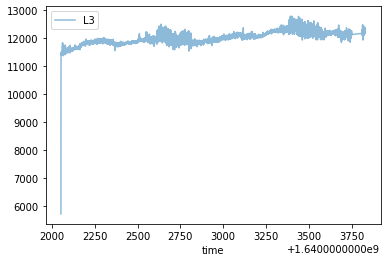

In [9]:
eeg_df.plot(y="L3", x="time", alpha=0.5)

## Preprocess (clean) the signals

Creating RawArray with float64 data, n_channels=16, n_times=213438
    Range : 0 ... 213437 =      0.000 ...  1707.496 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 62 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 62.49 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 62.50 Hz)
- Filter length: 41251 samples (330.008 sec)



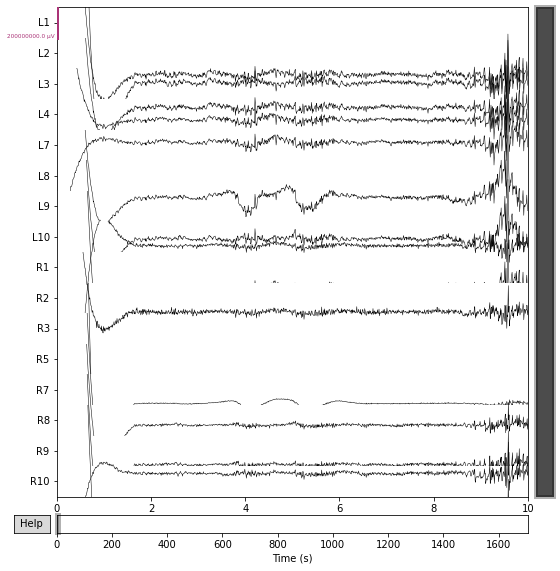

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 825 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 62 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 62.49 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 62.50 Hz)
- Filter length: 41251 samples (330.008 sec)



/var/folders/_y/gt9n5tsd34ldh0_7_57_md2h0000gn/T/ipykernel_10571/2126812158.py:15: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw = raw.copy().set_montage(ceegrid_montage)


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 413 samples (3.304 sec)

Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!
Interpolating bad channels
    Automatic origin fit: head of radius 94.7 mm
Computing interpolation matrix from 13 sensor positions
Interpolating 3 sensors


/var/folders/_y/gt9n5tsd34ldh0_7_57_md2h0000gn/T/ipykernel_10571/2126812158.py:32: RuntimeWarning: Only 8 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  raw = raw.interpolate_bads()


In [46]:
# %matplotlib qt

# Load EEG data into MNE Python for preprocessing
# Create MNE Python object
fs = 125 # Sampling frequency of the OpenBCI recording
ch_names = eeg_df.drop('time', axis=1).columns.values.tolist()
info = mne.create_info(ch_names, fs, ch_types='eeg')
raw = mne.io.RawArray(np.array(eeg_df.drop('time', axis = 1)).transpose(), info)

# High-Pass Filter & Plot for visual inspection
raw.copy().filter(l_freq = 1, h_freq = 62.49).plot(scalings=dict(eeg=100))

# Load custom montage (for cEEGrids) - these are the coordinates of the electrodes on the head
ceegrid_montage = mne.channels.read_custom_montage('ceegrid_sph.txt')
raw = raw.copy().set_montage(ceegrid_montage)

# Filter the data
raw = raw.notch_filter(freqs=(25, 50)) # Notch filter to remove power line noise
raw = raw.filter(l_freq = 1, h_freq = 62.49) # 1 Hz Highpass (detrend) & 62.5 Hz Lowpass (remove high-frequency artefacts)

# Detect (& interpolate) bad channels
# You can play around with this a bit if you like - it could also perform poorly in your experiment (the facial muscle artefacts are what you are interested in and should not necessarily be removed...)
raw.info['bads'] = []
nc = pyprep.NoisyChannels(raw, do_detrend=True, random_state=42)
nc.find_bad_by_SNR()
nc.find_bad_by_deviation()
nc.find_bad_by_hfnoise()
nc.find_bad_by_nan_flat()
nc.find_bad_by_ransac()
raw.info['bads'] = nc.get_bads()
# Interpolation can be done using mne python's interpolate_bads()
raw = raw.interpolate_bads()

## Cut the data

In [11]:
# Here you need to figure out now, how to extract the data per experiment condition/phase, 
# that you would like to extract features for; 
# Your goal is to get timestamps for when a part of the experiment started and when it ended.

# Some information that you might need here
# - You can use raw.get_data() to get to the cleaned signals and raw.times to get the now relative timestamps
# - You can also combine raw.get_data() with your original timestamps that you have in the .txt file
df1 = pd.DataFrame(raw.get_data())
df1 = df1.transpose()
df1[" Timestamp (Formatted)"] = df[" Timestamp (Formatted)"]
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Timestamp (Formatted)
0,-9.686925e-12,-2.776687e-12,-2.209812e-12,-5.284033e-13,3.957782e-13,-2.921966e-12,-4.095394e-12,-3.152974e-12,-1.145709e-12,-6.521787e-12,-5.667594e-12,-1.031298e-12,1.211468e-12,6.009082e-13,-4.999443e-13,-2.002664e-12,2021-12-20 13:07:32.699
1,1.407208e+04,5.026326e+03,5.529514e+03,1.265708e+03,-6.366470e+02,4.995699e+03,7.519633e+03,1.198707e+04,-5.044075e+03,3.296624e+03,9.994858e+03,1.053316e+04,8.253812e+03,1.035734e+04,3.850342e+03,-1.875173e+03,2021-12-20 13:07:32.705
2,1.399192e+04,4.996297e+03,5.493618e+03,1.250577e+03,-6.377789e+02,4.964828e+03,7.473140e+03,1.191817e+04,-5.017549e+03,3.296162e+03,9.959539e+03,1.048095e+04,8.205275e+03,1.029735e+04,3.823239e+03,-1.869533e+03,2021-12-20 13:07:32.711
3,1.386690e+04,4.937471e+03,5.440506e+03,1.235806e+03,-6.449931e+02,4.916097e+03,7.406638e+03,1.181590e+04,-4.980945e+03,3.259649e+03,9.873172e+03,1.039778e+04,8.142749e+03,1.022028e+04,3.794912e+03,-1.857084e+03,2021-12-20 13:07:32.719
4,1.379612e+04,4.909111e+03,5.408881e+03,1.234168e+03,-6.361013e+02,4.897595e+03,7.372177e+03,1.175889e+04,-4.948134e+03,3.255133e+03,9.833520e+03,1.034939e+04,8.102047e+03,1.016748e+04,3.775908e+03,-1.843988e+03,2021-12-20 13:07:32.727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213433,2.325403e+01,3.303410e+01,2.073489e+01,1.028928e+01,1.103640e+01,1.262075e+01,1.035690e+01,1.064689e+01,3.872663e+00,1.292011e+01,1.018957e+01,7.560037e-02,-3.471052e+00,-4.895089e+00,-4.190966e+00,-1.299045e+00,2021-12-20 13:37:08.858
213434,2.798107e+01,4.249110e+01,3.258752e+01,1.122737e+01,1.362833e+01,1.735723e+01,1.685903e+01,1.613773e+01,3.392218e+01,5.525265e+01,5.189518e+01,2.654593e+01,1.483057e+01,1.322706e+01,1.264007e+01,1.759596e+01,2021-12-20 13:37:08.866
213435,2.159477e+01,4.271660e+01,3.141864e+01,2.043500e+00,2.765477e-01,5.980557e+00,4.924603e+00,7.028249e+00,8.691643e+00,3.747902e+01,3.701818e+01,9.930049e+00,-2.438346e+00,-2.902402e+00,-2.732397e+00,1.225244e+00,2021-12-20 13:37:08.874
213436,1.327077e+01,7.398721e+00,5.608923e+00,1.707656e+00,-1.147407e+00,-1.551816e-01,-7.823787e-01,2.236133e+00,1.006311e+01,3.723129e+01,3.867650e+01,1.533215e+01,2.537992e-01,-2.909999e+00,-3.203170e+00,3.533743e+00,2021-12-20 13:37:08.881


In [12]:
import slicing
experiment_data = slicing.import_experiment_data()
sensor_data = slicing.convert_timestamps(df1)
routines = slicing.get_routine_times(experiment_data)
routines_data_dict = slicing.slice_data(routines, sensor_data)

/Users/lukasstingl/Desktop/EMUB/nourriture_cEEG/slicing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"]=key
/Users/lukasstingl/opt/anaconda3/envs/aiss/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/Users/lukasstingl/opt/anaconda3/envs/aiss/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [38]:
import numpy as np
transposed_test = routines_data_dict["yawning"][0].transpose()
feature_data = transposed_test.iloc[:-1:]
array = feature_data.to_numpy()


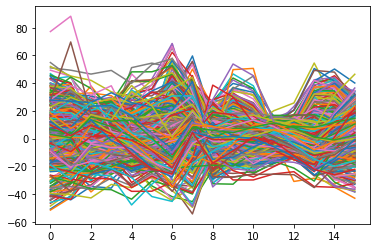

In [40]:
import matplotlib.pyplot as plt

plt.plot(array)

## Feature extraction

In [47]:
# Here you have to first decide how to process the data. There are two initial options:
# - Extract features on moving windows (e.g. extract one feature per electrode 
#   for every 2s of the experiment phase or one per electrode for the entire experiment phase)


# You can see which features we have extraced in our NeuroIS article...

# Here is an example of how you could extract frequency band powers (requires a numpy array):
epoch_duration_sec = 2
psds, freqs = mne.time_frequency.psd_array_welch(array, fmin=1, fmax=62.5, n_fft=int(fs*epoch_duration_sec), sfreq = 0.3)
psds = 10. * np.log10(psds) # db normalization

psd_simple_welch_df = pd.DataFrame(psds.transpose(), columns=raw.ch_names)
psd_simple_welch_df['Frequency'] = freqs

def get_band_power(low_bound, high_bound):
    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low_bound, freqs <= high_bound)
    return psds[:, idx_band].mean(axis=1)

theta = get_band_power(4, 7)
alpha = get_band_power(8, 13)
beta = get_band_power(14, 30)

Effective window size : 833.333 (s)


ValueError: No frequencies found between fmin=1 and fmax=62.5

## Classifier Training

In [ ]:
# Here your ML magic comes in...